# Creating synthetic data: 
## sc cells, advecting on mean flow, modulated by waves
### later: advected also by wave divergent winds

from chatGPT: We can break it down into smaller components: generating cloud cells, simulating their growth and decay, applying a mean wind drift, and adding a gentle wave-like field for modulation. Please note that this will be a simplified representation and not a physically accurate simulation. We'll use Python and some common libraries for this task.


## Units: km and hours 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

# Constants
grid_size_x_km = 1000  # Width of the domain in kilometers
grid_size_y_km = 1000  # Height of the domain in kilometers
grid_resolution = 2    # Grid resolution in kilometers
time_steps = 48        # Number of time steps (every half-hour for a day)
time_resolution = 0.5  # in hours
cloud_growth_time = 8  # Time in steps for cloud growth, same for decay
wave_wavelength = 200  # Wavelength of the gentle waves in kilometers
wave_speed = 40        # km/hour

mean_wind_speed = 30  # Mean wind speed in km/h
mean_wind_direction = 300/360. *(2*np.pi)  # 300 = TOWARD 300deg


num_cells = 6000       # Adjust the number of cloud cells as desired
max_size = 3            # pixel size of cloud cells, then they are smoothed
smoothing_size=2       # for gaussian filter smoother

# Create a grid
grid_size_x = int(grid_size_x_km / grid_resolution)
grid_size_y = int(grid_size_y_km / grid_resolution)
grid = np.zeros((grid_size_x, grid_size_y, time_steps))

# Next, we'll generate cloud cells with random positions, sizes, and ages. 
# Each cell will slowly grow and decay over time:

# Generate random cloud cells initially
cloud_cells = []
for _ in range(num_cells):
    x = np.random.randint(grid_size_x)
    y = np.random.randint(grid_size_y)
    size = np.random.randint(1, max_size)           # Size in grid cells 
    age = np.random.randint(cloud_growth_time * 2)  # random initial age 
    cloud_cells.append((x, y, size, age))

    
# Sum up the grid 
# all done in time step units 
# Simulate cloud growth and decay, updating the list of active clouds

for t in range(time_steps):
    #print('time step ',t)
    new_cloud_cells = []
    for cell in cloud_cells:
        x, y, size, age = cell
        #print('cell age ',age)
        if age < cloud_growth_time:
            # Growing phase
            grid[x-size:x+size, y-size:y+size, t] = age
            # age the cloud cell by 1
            age += 1
            #print('young cell aged to ',x,y,age)
        elif age < 2 * cloud_growth_time:
            # Decaying phase
            grid[x-size:x+size, y-size:y+size, t] = 2*cloud_growth_time -age
            # age the cloud cell by 1
            age += 1
            #print('old cell aged to ',x,y,age)
        if age >= 2 * cloud_growth_time: 
            # dead cell: remove it, and generate a new one age 0
            cloud_cells.remove(cell)
            #print('DEAD! # remaining cells: ',len(cloud_cells))
            x = np.random.randint(grid_size_x)
            y = np.random.randint(grid_size_y)
            size = np.random.randint(1, max_size)  # Size in grid cells 
            age = 0  
            cloud_cells.append((x, y, size, age))
            #print("dead at age ", age, "replaced with ",x, y, size, age)
            #print('# is back to: ',len(cloud_cells))
        #print('cell age ',x,age)    
        
        cell = x, y, size, age # zip it back up in the list
        new_cloud_cells.append(cell)

    # replace the old cells with the new aged ones 
    cloud_cells = new_cloud_cells.copy()
    new_cloud_cells.clear()
# Smoothing    
    grid[:,:,t] = sp.ndimage.gaussian_filter(grid[:,:,t].copy(), smoothing_size, mode='wrap')
    
    
# Now, with all grids computed, let's add a mean wind drift to the cloud pattern:

# Calculate the wind drift, converted to grid cells per time step
grid_drift_x = mean_wind_speed * np.cos(mean_wind_direction) \
               /grid_resolution *time_resolution  # Convert km/hr to grid/step
grid_drift_y = mean_wind_speed * np.sin(mean_wind_direction) \
               /grid_resolution *time_resolution  # Convert km/hr to grid/step

# Apply wind drift to the cloud pattern
for t in range(1, time_steps):
    grid[:, :, t] = np.roll(grid[:, :, t], int(grid_drift_x * t), axis=0)
    grid[:, :, t] = np.roll(grid[:, :, t], int(grid_drift_y * t), axis=1)

    
#Finally, let's multiply the gentle wave-like field for modulation:

# Generate wave coordinate mesh, in gridpoints, centers of cells +0.5 
x_wave = np.linspace(0, grid_size_x-1,grid_size_x)+0.5
y_wave = np.linspace(0, grid_size_y-1,grid_size_y)+0.5
x_wave, y_wave = np.meshgrid(x_wave, y_wave)

# Apply wave modulation to the cloud pattern: sin(kx-ft), f=speed(km/h)/wavelength(km)
for t in range(time_steps):
    wave_modulation = np.sin(x_wave*grid_resolution * (2 *np.pi / wave_wavelength) +\
                             y_wave*grid_resolution * (2 *np.pi / wave_wavelength) -\
                             t*time_resolution *wave_speed/wave_wavelength * (2 *np.pi) )
                      #np.sin(t * (2 * np.pi) * wave_speed) 
    grid[:, :, t] *= (1 + 0.5*wave_modulation)

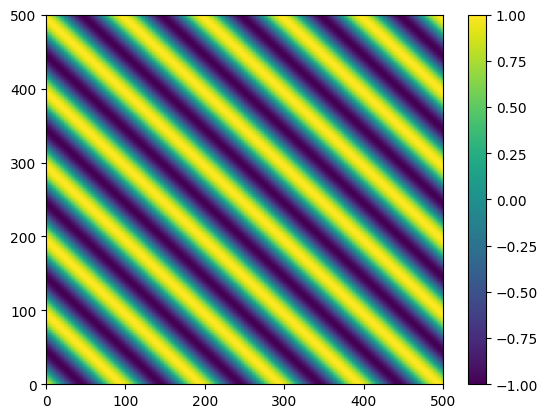

In [4]:
plt.pcolormesh(wave_modulation); plt.colorbar()

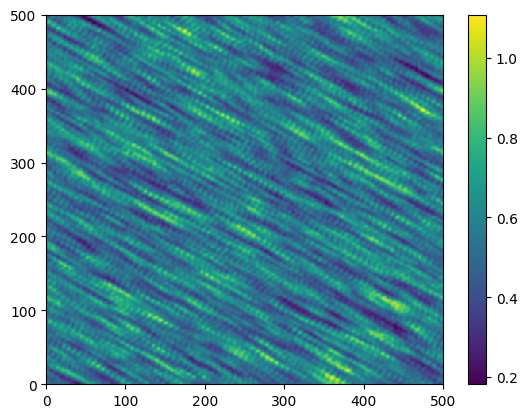

In [5]:
plt.pcolormesh(grid.mean(axis=2)); plt.colorbar()

In [6]:
grid.max()

8.86470804465928

In [7]:
2*cloud_growth_time/2

8.0

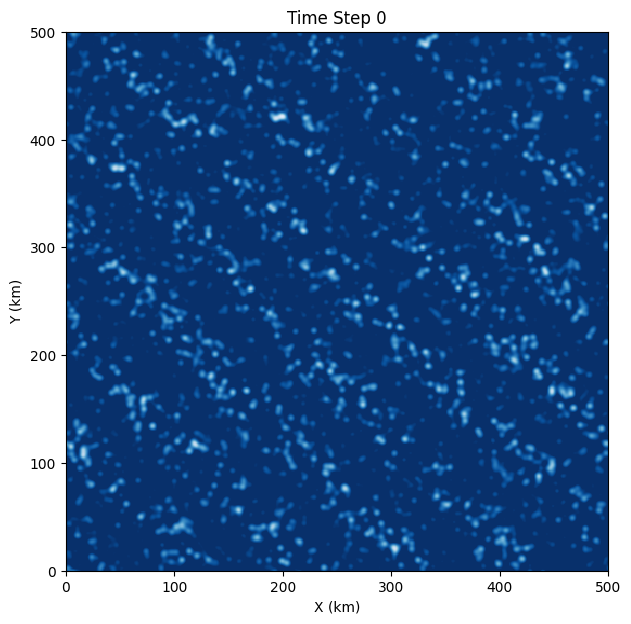

In [8]:
grid = grid.max()-grid # invert values! for blue color scale

from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create a figure and axis
fig, ax = plt.subplots(figsize=(7, 7))  

# Function to initialize the animation at frame 10 
def init():
    im = ax.pcolormesh(grid[:, :, 0],vmin=0,vmax=2*cloud_growth_time/2,cmap='Blues')
    plt.title(f'Time Step 0')
    plt.xlabel('X (km)')
    plt.ylabel('Y (km)')
    return [im]

# Function to animate the frames
def animate(t):
    im = ax.pcolormesh(grid[:, :, t],vmin=0,vmax=2*cloud_growth_time/2,cmap='Blues')
    plt.title(f'Time Step {t}')
    return [im]

# Create an animation
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=22, repeat=True)

# Display the animation in the Jupyter Notebook
HTML(ani.to_jshtml())


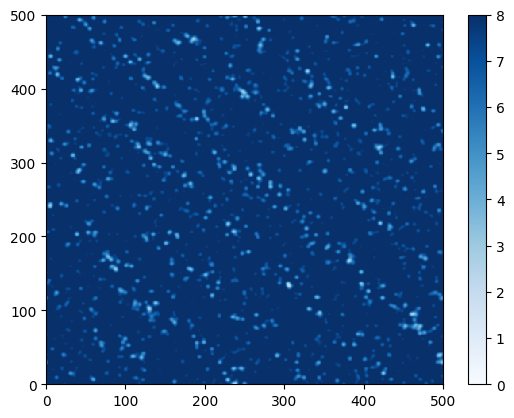

In [9]:
plt.pcolormesh(grid[:, :, 22],vmin=0,vmax=2*cloud_growth_time/2,cmap='Blues'); plt.colorbar()

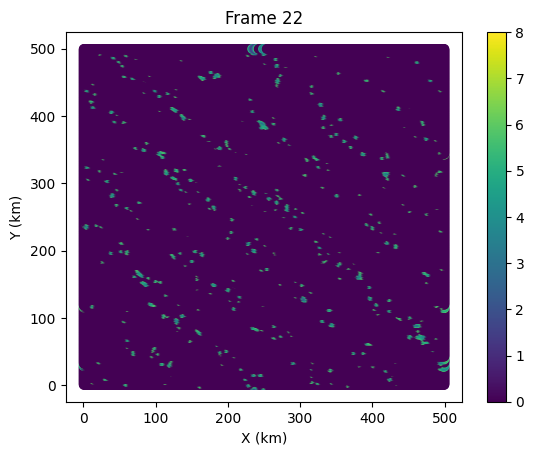

In [10]:
#Run this line if you haven't run the animation cell
#grid = grid.max()-grid # invert values! for blue color scale

# Select a frame to cluster
frame_index = 22

# Filter the grid to values equal to 1 or less
filtered_grid = grid[:, :, frame_index].copy()
filtered_grid[filtered_grid > 6] = 0

# Reshape the grid to a 2D array
grid_2d = filtered_grid.reshape(-1, 1)

#plot the grid
plt.scatter(x_wave.flatten(), y_wave.flatten(), c=grid_2d, cmap='viridis')
plt.colorbar()

#Define the colorbar's limits
plt.clim(0, 8)

plt.title(f'Frame {frame_index}')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.show()


In [11]:
# reduction_value = 2

# count = np.count_nonzero(grid_2d)
# print(count)

# # Calculate the new grid size
# new_grid_size_x = int(grid_size_x / reduction_value)
# new_grid_size_y = int(grid_size_y / reduction_value)

# # Reshape the grid to the new size
# new_grid_2d = grid_2d.reshape(grid_size_x, grid_size_y)[::reduction_value, ::reduction_value].reshape(new_grid_size_x * new_grid_size_y, 1)

# # Calculate the new count
# new_count = np.count_nonzero(new_grid_2d)

# print(new_count)

# # Plot the new grid
# plt.scatter(x_wave[::reduction_value, ::reduction_value].flatten(), y_wave[::reduction_value, ::reduction_value].flatten(), c=new_grid_2d, cmap='viridis')
# plt.colorbar()
# plt.title(f'Frame {frame_index} (Reduced)')
# plt.xlabel('X (km)')
# plt.ylabel('Y (km)')
# plt.show()




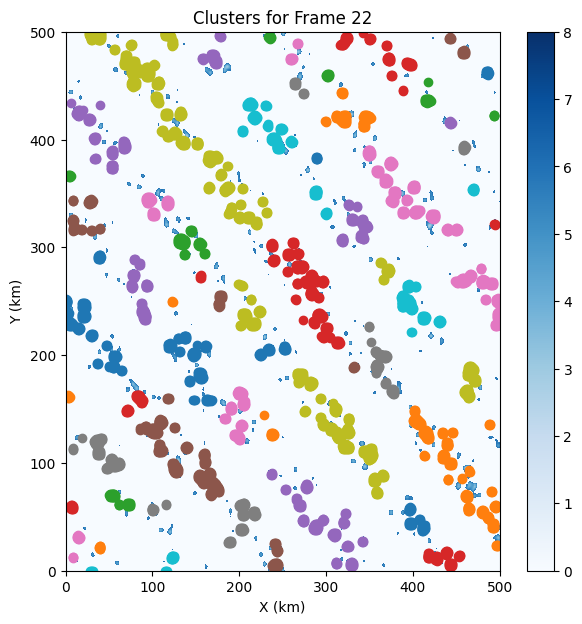

In [12]:
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression

# Select a frame to cluster
frame_index = 22

coords_array = np.nonzero(filtered_grid)
#convert the tuples into and array
coords_array = np.array(coords_array)
# transpose the coords_array
coords_array = coords_array.T

# Cluster the values equal to 3 or less
dbscan = DBSCAN(eps=20, min_samples=1)
labels = dbscan.fit_predict(coords_array)

# Get the unique cluster labels
unique_labels = np.unique(labels)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(7, 7))

# Plot the original frame picture
im = ax.pcolormesh(grid_2d.reshape(grid_size_x, grid_size_y), vmin=0, vmax=2*cloud_growth_time/2, cmap='Blues')

# Plot the clusters
for label in unique_labels:
    if label == -1:
        # Plot noise points in black
        noise_indices = np.where(labels == label)[0]
        ax.scatter(coords_array[noise_indices, 0], coords_array[noise_indices, 1], color='black', alpha=0.5)
    else:
        # Plot clustered points in different colors
        cluster_indices = np.where(labels == label)[0]
        ax.scatter(coords_array[cluster_indices, 0], coords_array[cluster_indices, 1], label=f'Cluster {label}')

plt.colorbar(im)
plt.title(f'Clusters for Frame {frame_index}')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
#plt.legend()
plt.show()

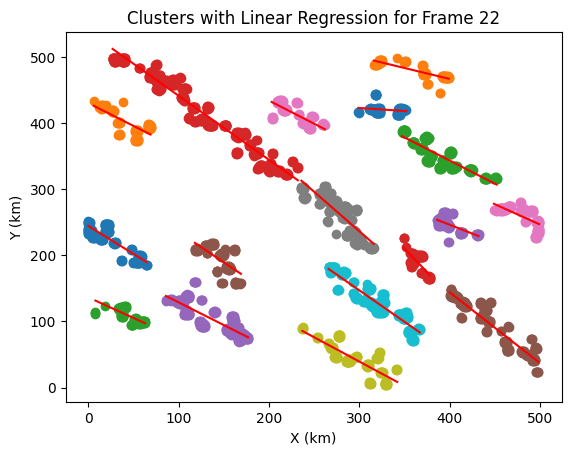

In [13]:
regression_lines = []

for label in unique_labels:
    if label != -1:
        # Get the indices of points in the cluster
        cluster_indices = np.where(labels == label)[0]
        
        # Get the x and y coordinates of the cluster points
        cluster_x = coords_array[cluster_indices, 0]
        cluster_y = coords_array[cluster_indices, 1]
        
        # Fit a linear regression model to the cluster points
        regression_model = LinearRegression()
        regression_model.fit(cluster_x.reshape(-1, 1), cluster_y)
        
        # Get the predicted y values from the regression model
        predicted_y = regression_model.predict(cluster_x.reshape(-1, 1))
        
        # Calculate the length of the regression line
        regression_length = np.sqrt((cluster_x.max() - cluster_x.min())**2 + (predicted_y.max() - predicted_y.min())**2)
        
        # Plot the cluster points and the regression line on the initial frame figure
        if regression_length > 50:
            plt.scatter(cluster_x, cluster_y, label=f'Cluster {label}')
            plt.plot(cluster_x, predicted_y, color='red')             
            
            # Get the start and finish points of the regression line
            start_point = (cluster_x[0], predicted_y[0])
            finish_point = (cluster_x[-1], predicted_y[-1])
            
            # Create a list with the start and finish points of the regression line
            regression_line = [start_point, finish_point]
            regression_lines.append(regression_line)

# Add legend and labels to the plot
plt.colorbar(im)
plt.title(f'Clusters with Linear Regression for Frame {frame_index}')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
#plt.legend()
plt.show()

In [14]:
# Redefining all necessary intermediate functions 

import numpy as np

def line_to_vector(line):
    """Convert line endpoints to a vector."""
    point1, point2 = line
    return np.array([point2[0] - point1[0], point2[1] - point1[1]])

def dot_product(vec1, vec2):
    """Calculate the dot product between two vectors."""
    return np.dot(vec1, vec2)

def average_dot_product(line, lines):
    """Calculate the average dot product of a line with all other lines."""
    vec1 = line_to_vector(line)
    total_dot_product = sum(dot_product(vec1, line_to_vector(other_line)) for other_line in lines)
    return abs(total_dot_product / len(lines))


In [15]:
def optimize_line_with_initial_candidates(lines, x_range, y_range, line_length, learning_rate, num_iterations, num_candidates):
    """
    Optimize the angle of a line (positioned at the center) by first generating a fixed number of candidate lines
    with uniformly distributed angles, and then applying gradient descent starting from the best candidate.
    """
    def compute_gradient(angle, lines, center, line_length):
        """
        Compute the gradient of the average dot product with respect to the angle.
        We use a numerical approach to approximate the gradient.
        """
        epsilon = 1e-5
        candidate_line = create_line_from_angle(center, angle, line_length)
        original_avg_dot = average_dot_product(candidate_line, lines)
        
        # Perturb the angle slightly and compute the gradient
        perturbed_line = create_line_from_angle(center, angle + epsilon, line_length)
        perturbed_avg_dot = average_dot_product(perturbed_line, lines)
        gradient = (perturbed_avg_dot - original_avg_dot) / epsilon

        return gradient
    
    def create_line_from_angle(center, angle, length):
        """
        Create a line from a given angle with a fixed length, starting from the center.
        """
        x2 = center[0] + length * np.cos(angle)
        y2 = center[1] + length * np.sin(angle)
        return [center, (x2, y2)]

    # Center of the range
    center = (x_range / 2, y_range / 2)

    # Generate initial candidate lines with uniformly distributed angles
    angles = np.linspace(0, 2 * np.pi, num_candidates, endpoint=False)
    candidates = [create_line_from_angle(center, angle, line_length) for angle in angles]

    # Evaluate each candidate and select the best one
    best_candidate = min(candidates, key=lambda line: average_dot_product(line, lines))

    # Perform gradient descent starting from the best candidate
    best_angle = np.arctan2(best_candidate[1][1] - center[1], best_candidate[1][0] - center[0])
    best_avg_dot_product = average_dot_product(best_candidate, lines)

    for _ in range(num_iterations):
        # Compute gradient using the same method as before
        grad = compute_gradient(best_angle, lines, center, line_length)

        # Update the angle in the opposite direction of the gradient
        best_angle -= learning_rate * grad

        # Ensure the angle is within the valid range [0, 2π)
        best_angle = best_angle % (2 * np.pi)

        # Calculate the average dot product for the current angle
        candidate_line = create_line_from_angle(center, best_angle, line_length)
        avg_dot_product = average_dot_product(candidate_line, lines)
        if avg_dot_product < best_avg_dot_product:
            best_avg_dot_product = avg_dot_product
            best_candidate = candidate_line

    return best_candidate


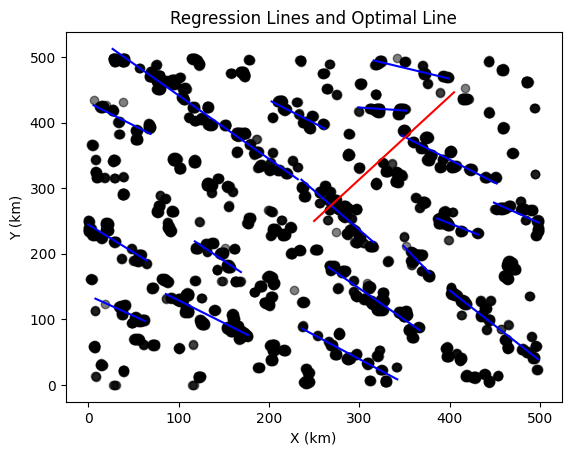

51.728187267778864

In [16]:
lines = regression_lines
x_range = grid_size_x
y_range = grid_size_y
line_length = 250
learning_rate = 0.1
num_iterations = 1000
num_candidates = 100

#optimal_line = optimize_line_angle(lines, x_range, y_range, line_length, learning_rate, num_iterations)
optimal_line = optimize_line_with_initial_candidates(lines, x_range, y_range, line_length, learning_rate, num_iterations, num_candidates)

#plot the regression lines and the optimal line
plt.scatter(coords_array[:, 0], coords_array[:, 1], color='black', alpha=0.5)
for line in regression_lines:
    plt.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], color='blue')
plt.plot([optimal_line[0][0], optimal_line[1][0]], [optimal_line[0][1], optimal_line[1][1]], color='red')
plt.title('Regression Lines and Optimal Line')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.show()

# show the optimal line angle 
angle = np.arctan2(optimal_line[1][1] - optimal_line[0][1], optimal_line[1][0] - optimal_line[0][0])
angle * 180 / np.pi


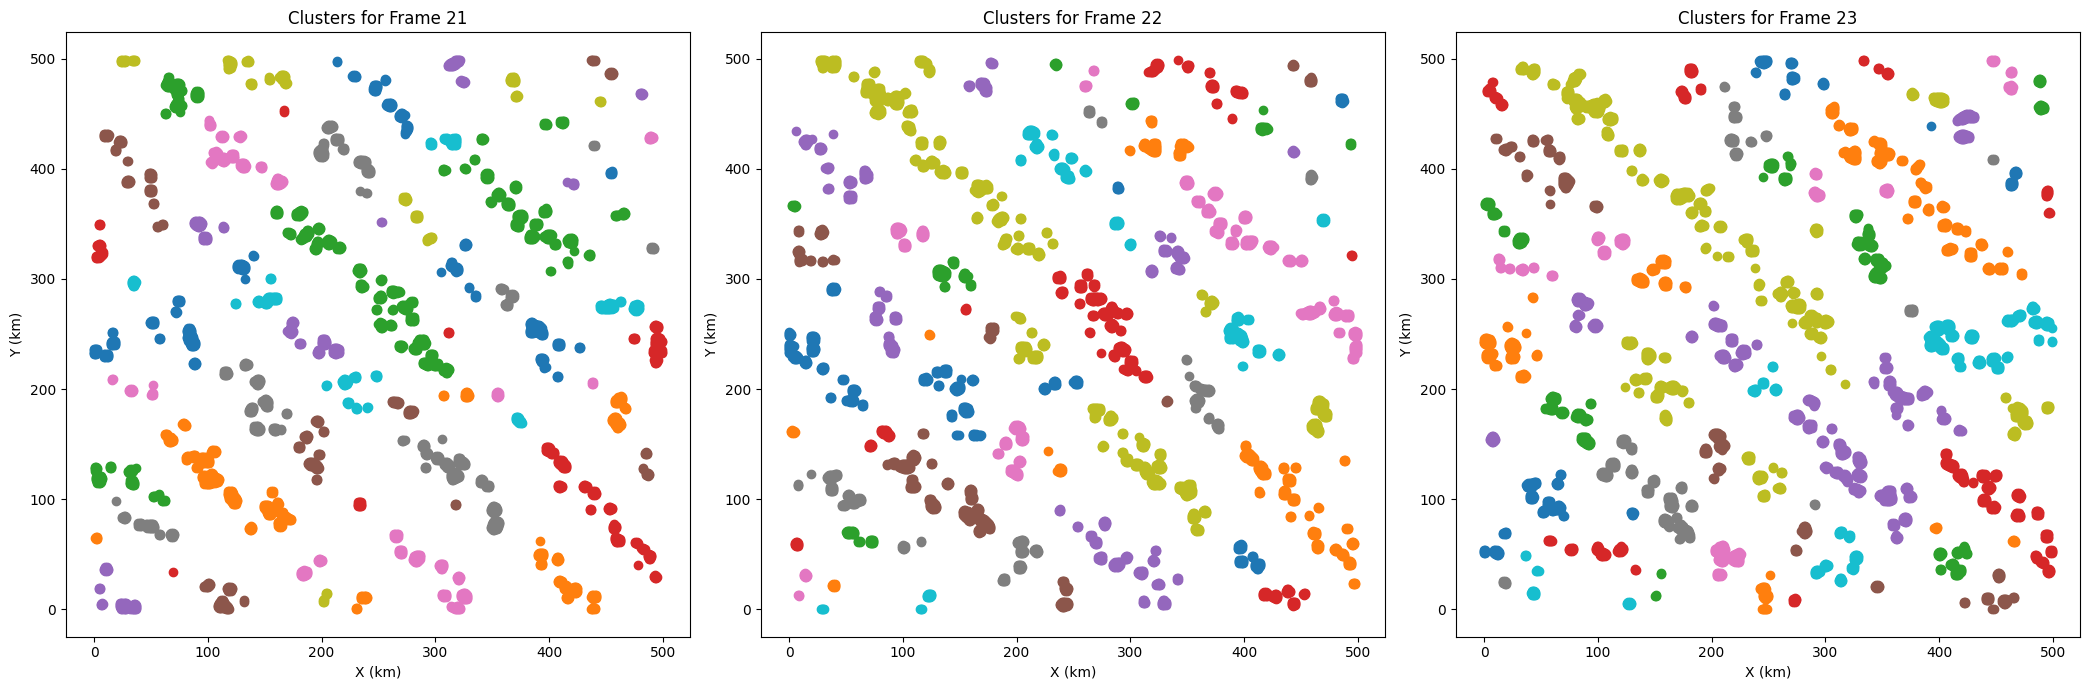

In [17]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Create a figure and axis for the subplots
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# Iterate over the frames 21 to 23
for i, frame_index in enumerate(range(21, 24)):
    # Filter the grid to values equal to 1 or less
    filtered_grid = grid[:, :, frame_index].copy()
    filtered_grid[filtered_grid > 6] = 0

    # Reshape the grid to a 2D array
    grid_2d = filtered_grid.reshape(-1, 1)

    coords_array = np.nonzero(filtered_grid)
    # Convert the tuples into and array and transpose it
    coords_array = np.array(coords_array).T

    # Cluster the values equal to 3 or less
    dbscan = DBSCAN(eps=20, min_samples=1)
    labels = dbscan.fit_predict(coords_array)

    # Get the unique cluster labels
    unique_labels = np.unique(labels)

    # Plot the original frame picture
    #im = axs[i].pcolormesh(grid_2d.reshape(grid_size_x, grid_size_y), vmin=0, vmax=2*cloud_growth_time/2, cmap='Blues')

    # Plot the clusters
    for label in unique_labels:
        if label == -1:
            # Plot noise points in black
            noise_indices = np.where(labels == label)[0]
            axs[i].scatter(coords_array[noise_indices, 0], coords_array[noise_indices, 1], color='black', alpha=0.5)
        else:
            # Plot clustered points in different colors
            cluster_indices = np.where(labels == label)[0]
            axs[i].scatter(coords_array[cluster_indices, 0], coords_array[cluster_indices, 1], label=f'Cluster {label}')

    axs[i].set_title(f'Clusters for Frame {frame_index}')
    axs[i].set_xlabel('X (km)')
    axs[i].set_ylabel('Y (km)')

# Adjust the spacing between subplots and add a color bar
plt.tight_layout()
#fig.colorbar(im, ax=axs.ravel().tolist())

# Display the plots
plt.show()




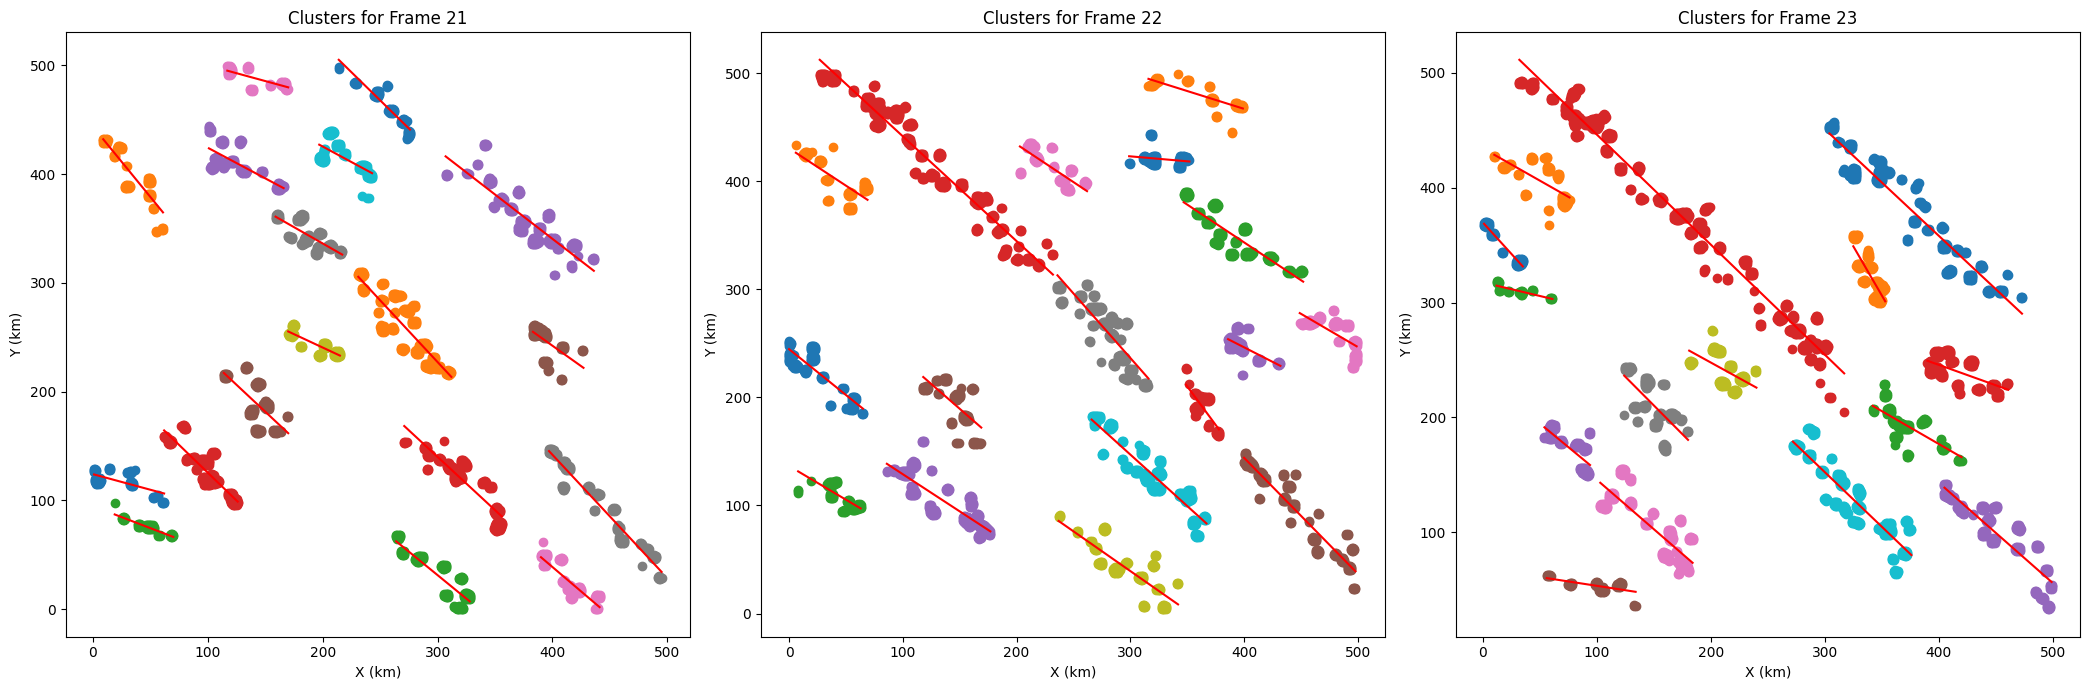

In [18]:
# Create a figure and axis for the subplots
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# Iterate over the frames 21 to 23
for i, frame_index in enumerate(range(21, 24)):
    # Filter the grid to values equal to 1 or less
    filtered_grid = grid[:, :, frame_index].copy()
    filtered_grid[filtered_grid > 6] = 0

    # # Reshape the grid to a 2D array
    # grid_2d = filtered_grid.reshape(-1, 1)

    coords_array = np.nonzero(filtered_grid)
    # Convert the tuples into and array and transpose it
    coords_array = np.array(coords_array).T

    # Cluster the values equal to 3 or less
    dbscan = DBSCAN(eps=20, min_samples=1)
    labels = dbscan.fit_predict(coords_array)

    # Get the unique cluster labels
    unique_labels = np.unique(labels)

    regression_lines = []

    for label in unique_labels:
        if label != -1:
            # Get the indices of points in the cluster
            cluster_indices = np.where(labels == label)[0]
            
            # Get the x and y coordinates of the cluster points
            cluster_x = coords_array[cluster_indices, 0]
            cluster_y = coords_array[cluster_indices, 1]
            
            # Fit a linear regression model to the cluster points
            regression_model = LinearRegression()
            regression_model.fit(cluster_x.reshape(-1, 1), cluster_y)
            
            # Get the predicted y values from the regression model
            predicted_y = regression_model.predict(cluster_x.reshape(-1, 1))
            
            # Calculate the length of the regression line
            regression_length = np.sqrt((cluster_x.max() - cluster_x.min())**2 + (predicted_y.max() - predicted_y.min())**2)
            
            # Plot the cluster points and the regression line on the initial frame figure
            if regression_length > 50:
                axs[i].scatter(cluster_x, cluster_y, label=f'Cluster {label}')
                axs[i].plot(cluster_x, predicted_y, color='red')             
                
                # Get the start and finish points of the regression line
                start_point = (cluster_x[0], predicted_y[0])
                finish_point = (cluster_x[-1], predicted_y[-1])
                
                # Create a list with the start and finish points of the regression line
                regression_line = [start_point, finish_point]
                regression_lines.append(regression_line)
                
        axs[i].set_title(f'Clusters for Frame {frame_index}')
        axs[i].set_xlabel('X (km)')
        axs[i].set_ylabel('Y (km)')

# Adjust the spacing between subplots and add a color bar
plt.tight_layout()
#fig.colorbar(im, ax=axs.ravel().tolist())

# Display the plots
plt.show()


In [232]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression
import random

# Function to calculate the distance between two lines based on their slopes and intercepts
def calculate_line_distance(slope1, intercept1, slope2, intercept2, position1, position2):
    # Check the relative distance of the two centroids
    centroid_distance = np.sqrt((position1[0][0] - position2[0][0])**2 + (position1[0][1] - position2[0][1])**2)
    # Calculate the angle between the two lines
    #angle = np.arctan(abs((slope2 - slope1) / (1 + slope1 * slope2)))
    # Calculate the distance between the two lines
    #distance = centroid_distance * np.sin(angle)
    distance = centroid_distance
    return distance

# Function to get the slope and intercept of a regression line
def get_line_parameters(x, y):
    regression_model = LinearRegression()
    regression_model.fit(x.reshape(-1, 1), y)
    slope = regression_model.coef_[0]
    intercept = regression_model.intercept_
    position = ([x[0], y[0]], [x[-1], y[-1]])
    return slope, intercept, position

# Function to check the length of a regression line of a cluster
def check_line_length(label):
    cluster_indices = np.where(labels == label)[0]
    cluster_x = coords_array[cluster_indices, 0]
    cluster_y = coords_array[cluster_indices, 1]
    regression_model = LinearRegression()
    regression_model.fit(cluster_x.reshape(-1, 1), cluster_y)
    predicted_y = regression_model.predict(cluster_x.reshape(-1, 1))
    regression_length = np.sqrt((cluster_x.max() - cluster_x.min())**2 + (predicted_y.max() - predicted_y.min())**2)
    return regression_length


In [247]:
# Enhanced function to track regression line, with diagnostics for troubleshooting
from calendar import c
from threading import currentThread


def track_regression_line(grid, verbose=False):
    # Create a figure and axis for the subplots
    fig, axs = plt.subplots(1, 3, figsize=(21, 7))

    # Initialize variables to store the tracked line parameters
    tracked_slope, tracked_intercept = None, None
    tracked_label = None

    # Iterate over the frames 21 to 23
    #for i, frame_index in enumerate(range(21, 24)):
    for i, frame_index in enumerate([21, 25, 29]):
        # Filter the grid to values equal to 1 or less
        filtered_grid = grid[:, :, frame_index].copy()
        filtered_grid[filtered_grid > 6] = 0

        coords_array = np.nonzero(filtered_grid)
        # Convert the tuples into an array and transpose it
        coords_array = np.array(coords_array).T

        # Cluster the values equal to 3 or less
        dbscan = DBSCAN(eps=20, min_samples=2)
        labels = dbscan.fit_predict(coords_array)
        
        # Get the unique cluster labels
        unique_labels = np.unique(labels)

        # In the first frame, pick a random line to track
        if i == 0:
                # Filter the unique_labels to only include those that satisfy the condition
                filtered_labels = [label for label in unique_labels if label != -1 and check_line_length(label) > 50]           
                tracked_label = random.choice(filtered_labels)


        line_parameters = []
        for label in unique_labels:
            if label != -1:
                # Get the indices of points in the cluster
                cluster_indices = np.where(labels == label)[0]

                # Get the x and y coordinates of the cluster points
                cluster_x = coords_array[cluster_indices, 0]
                cluster_y = coords_array[cluster_indices, 1]

                # Get the slope, intercept and position of the current line
                current_slope, current_intercept, current_position = get_line_parameters(cluster_x, cluster_y)
                line_parameters.append((label, current_slope, current_intercept, current_position))

                if i == 0 and label == tracked_label:
                    # Store the parameters of the tracked line
                    tracked_slope, tracked_intercept, tracked_position = current_slope, current_intercept, current_position

        # Rank the candidates based on distance to the tracked line
        candidates = []
        if i > 0:
            candidates = sorted(line_parameters, key=lambda x: calculate_line_distance(tracked_slope, tracked_intercept, x[1], x[2], tracked_position, x[3]))

            #choose the best candidate that needs to have a min length of 50
            for label, slope, intercept, position in candidates:
                if check_line_length(label) > 75:
                    best_label = label
                    tracked_label, tracked_slope, tracked_intercept, tracked_position = best_label, slope, intercept, position
                    break
            
            # Logging for troubleshooting
            if verbose:
                print(f"Frame {frame_index}: Tracked line - Label: {tracked_label}, Slope: {tracked_slope}, Intercept: {tracked_intercept}")
                print("Candidates sorted by distance (label, slope, intercept, distance):")
                for label, slope, intercept, position in candidates:
                    distance = calculate_line_distance(tracked_slope, tracked_intercept, slope, intercept, tracked_position, position)
                    print(f"Label: {label}, Slope: {slope}, Intercept: {intercept}, Distance: {distance}")

        # Plotting and visualization
        for label, slope, intercept, position in line_parameters:
            cluster_indices = np.where(labels == label)[0]
            cluster_x = coords_array[cluster_indices, 0]
            cluster_y = coords_array[cluster_indices, 1]

            regression_model = LinearRegression()
            regression_model.fit(cluster_x.reshape(-1, 1), cluster_y)
            predicted_y = regression_model.predict(cluster_x.reshape(-1, 1))

            # Choose color based on the label
            if i==0 and label == tracked_label:
                color = 'red'
                # Annotate the tracked line
                axs[i].annotate(f'Tracked\nLabel: {label}', 
                                (np.mean(cluster_x), np.mean(cluster_y)),
                                textcoords="offset points", 
                                xytext=(0,10), 
                                ha='center')
            elif i > 0 and label == best_label:
                color = 'red'
                # Annotate the tracked line
                axs[i].annotate(f'Tracked\nLabel: {label}', 
                                (np.mean(cluster_x), np.mean(cluster_y)),
                                textcoords="offset points", 
                                xytext=(0,10), 
                                ha='center')
            elif i > 0 and any(label == candidate_label for candidate_label, _, _,_ in candidates[:5]): # Top 5 candidates
                color = 'green'
                # Annotate the tracked line
                axs[i].annotate(f'Candidate\nLabel: {label}', 
                                (np.mean(cluster_x), np.mean(cluster_y)),
                                textcoords="offset points", 
                                xytext=(0,10), 
                                ha='center')
            else:
                color = 'black'

            axs[i].scatter(cluster_x, cluster_y, label=f'Cluster {label}')
            axs[i].plot(cluster_x, predicted_y, color=color)

            # Display ranking information for top candidates
            if label == tracked_label and i > 0:
                axs[i].text(0.05, 0.95, f'Tracked Line: {label}\nTop Candidates:\n' + '\n'.join(f'{lbl}: {dist:.2f}' for lbl, dist in [(cand[0], calculate_line_distance(tracked_slope, tracked_intercept, cand[1], cand[2], tracked_position, cand[3])) for cand in candidates[:5]]), transform=axs[i].transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.5))

        axs[i].set_title(f'Clusters for Frame {frame_index}')
        axs[i].set_xlabel('X (km)')
        axs[i].set_ylabel('Y (km)')

    # Adjust the spacing between subplots and add a color bar
    plt.tight_layout()
    plt.show()



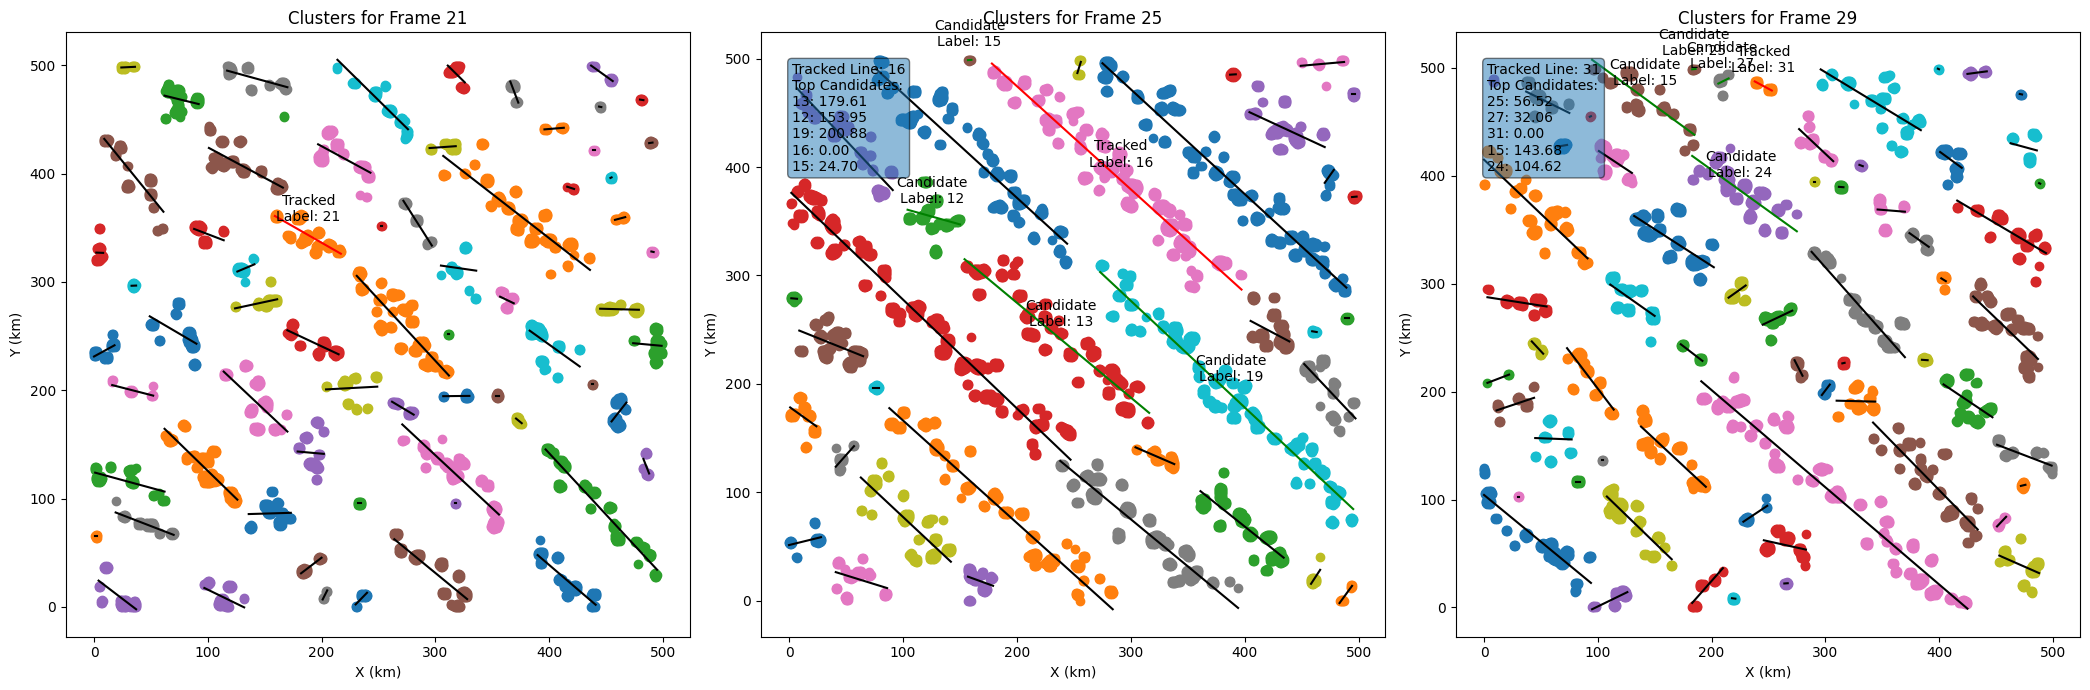

In [249]:
track_regression_line(grid, verbose=False)

In [218]:
tracked_label

41